# day 316, day 321,day 323, day 324,325,326,327,329,330,331

In [1]:
import numpy as np
import torch,torchvision
import matplotlib.pyplot as plt
from pathlib import Path
import os,requests,zipfile
from PIL import Image
from matplotlib.image import imread

# Transformer for images:

* Transformer algorthims are renowned in the area of natural language processing where the model will process 1D array of texts, but here instead of 1D texts we use 3D images (H,W,C) to classify these images correctly according to their label.

* Transformer uses self-attention to weigh different parts of the data differently based on significance the weight alters.

# Machine Learning Research Paper:

## why replicate a machine learning research paper?

if you want skills to be a great machine learning engineer:
  1. download a research paper.
  2. replicate what is in the paper.
  3. repeat it until you get the needful skills.
  4. most important thing is no one understands a paper the first time they read it, it takes many times but the challenge is completing it until you move onto the next one.


## finding machine learning papers:
* ! link: [An image is worth 16*16 words paper](https://arxiv.org/abs/2010.11929)
  

# getting the modules from github

In [ ]:
!git clone https://github.com/mrdbourke/pytorch-deep-learning
!mv pytorch-deep-learning/going_modular .
!rm -rf pytorch-deep-learning

Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Counting objects: 100% (1234/1234), done.
remote: Compressing objects: 100% (110/110), done.


# get the data:

In [ ]:
image_path = Path('data/Images')
image_path.mkdir(parents=True,exist_ok=True)

# download the data into data path
with open(Path('data/pizza_steak_sushi.zip') ,'wb') as f:
  response = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip').content
  f.write(response)

# unzip the zipfile
with zipfile.ZipFile('data/pizza_steak_sushi.zip','r') as zip:
  zip.extractall(image_path) # extract the contents to image_path
  zip.close()

# create dataloaders and datasets

In [ ]:
# train_dir and test_dir:
train_dir = 'data/Images/train'
test_dir = 'data/Images/test'

# creating datasets and dataloaders:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize([224,224]), # as per the paper.
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor()
])

batch_size = 32
num_workers = os.cpu_count()

from going_modular.going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = transform,
    batch_size = batch_size,
    num_workers = num_workers
)

train_dataset = train_dataloader.dataset
test_dataset = test_dataloader.dataset

In [ ]:
help(data_setup.create_dataloaders)

Help on function create_dataloaders in module going_modular.going_modular.data_setup:

create_dataloaders(train_dir: str, test_dir: str, transform: torchvision.transforms.transforms.Compose, batch_size: int, num_workers: int = 2)
    Creates training and testing DataLoaders.
    
    Takes in a training directory and testing directory path and turns
    them into PyTorch Datasets and then into PyTorch DataLoaders.
    
    Args:
      train_dir: Path to training directory.
      test_dir: Path to testing directory.
      transform: torchvision transforms to perform on training and testing data.
      batch_size: Number of samples per batch in each of the DataLoaders.
      num_workers: An integer for number of workers per DataLoader.
    
    Returns:
      A tuple of (train_dataloader, test_dataloader, class_names).
      Where class_names is a list of the target classes.
      Example usage:
        train_dataloader, test_dataloader, class_names =         = create_dataloaders(train_d

In [ ]:
len(train_dataloader),len(test_dataloader)

(8, 3)

# visualize a random image

sushi


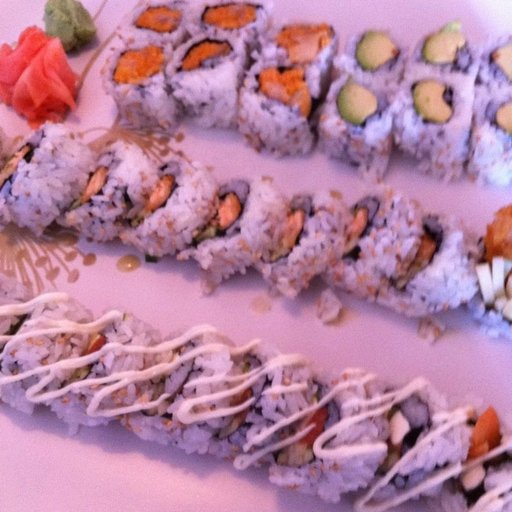

In [ ]:
image_paths = list(Path('data/Images').glob('*/*/*.jpg'))

# choose a random image path to display
rip = np.random.choice(image_paths,1)[0]
label = rip.parent.stem

# display it
print(label)
Image.open(rip)

# overview of a model:
1. inputs
2. outputs
3. layers: these are functions that transforms the inputs into something
4. blocks: these are collections of layers.
5. model: this is a collection of many blocks put together.

# model we are trying to build in this notebook:

##  model architecure overview:
![sfsdf](https://github.com/lucidrains/vit-pytorch/raw/main/images/vit.gif)
![fsf](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-figure-1-architecture-overview.png)

## four equations:
![sfsf](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-four-equations.png)

## table1:
![fsfsd](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-table-1.png)


## Layers, Blocks and the whole model architecture:
* Layers: A layers is any neural layer. It takes an input and performs a function on it. and it returns the output.
* Block: A block is collection of many layers put together.
* Model architecture: is a collection of many blocks.

![fsfsf](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-intputs-outputs-layers-and-blocks.png)

## Breaking down equation 1:

* $$ \begin{aligned}
\mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}
\end{aligned}  $$
* This equation deals with the class token, patch embedding and position embedding (
E is for embedding) of the input image.

* pseudocode:
```python
# equation1:
z_0 = [x_class + image_patch1 + image_patch2 + .....image_patchN] + [x_class_pos + image_patch1_pos + image_patch2_pos ....image_patchN_pos]...
```
* the x_class is the class name of the image.
* everything about the first equation in the equations image is pretty much self explanatory.


## Breaking down equation 2 & 3:
* $$ \begin{aligned}
\mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L
\end{aligned} $$
* This says that for every layer from  
1 through to L (the total number of layers), there's a Multi-Head Attention layer (MSA) wrapping a LayerNorm layer (LN).
* MSA is multi headed self attention layer.
* LA is LayerNorm.
* z_l -1 is the residual connections. this is for skipping the steps. This actually prevent the gradients from getting too small before the algorithm reaches the finalth layer. The best analogy is setting up a ramp to move from one floor to another rather than using traditional staircases.

* $$ \begin{aligned}
\mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\end{aligned} $$
* This says that for every layer from  
1 through to  L (the total number of layers), there's also a Multilayer Perceptron layer (MLP) wrapping a LayerNorm layer (LN).
* pseudo_code:
```python
# equation2:
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input
# equation3:
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```
* MLP layer stands for multi layered perceptron. which is just a feed forward fully connected Dense layer with a non-linear activation function such as 'relu', 'tanh', 'sigmoid', 'softmax' and so on ....

# Breaking down equation 4:
* $$ \begin{aligned}
\mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & &
\end{aligned} $$
* This says for the last layer  L, the output  y is the 0 index token of  z wrapped in a LayerNorm layer (LN).
* MLP = one hidden layer at training time.
* MLP = single linear layer at fine-tuning time.
* pseudo code:
```python
# equation4:
y = MLP(LN_layer(x_ouput_MLP_block))




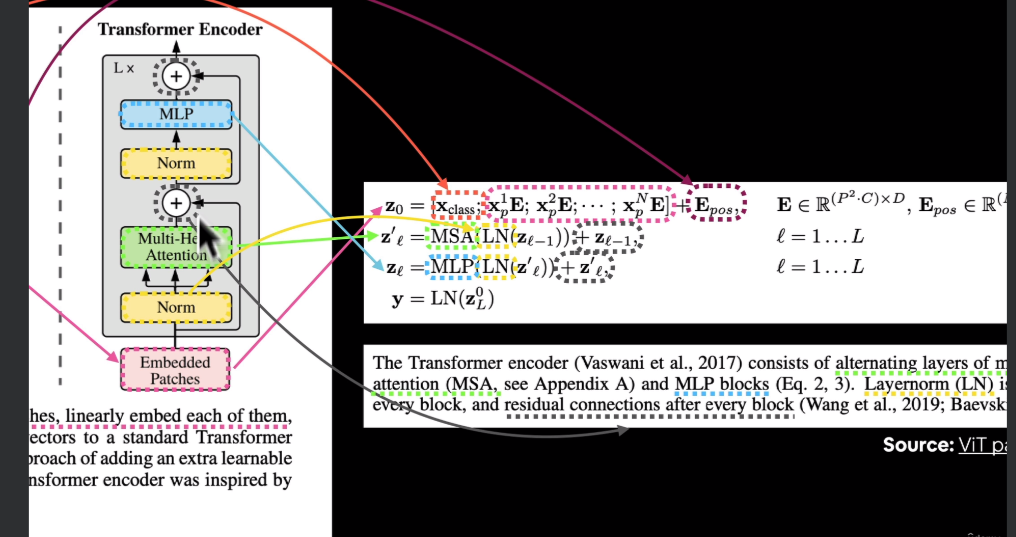

In [ ]:
Image.open('/content/drive/MyDrive/040324_dl.png')

# Mrdbourke's approach to reading Research papers;

When I start working on replicating a paper, I go through the following steps:
1. Read the whole paper end-to-end once (to get an idea of the main concepts).
2. Go back through each section and see how they line up with each other and start thinking about how they might be turned into code (just like above).
3. Repeat step 2 until you've got a fairly good outline.
4. Use mathpix.com (a very handy tool) to turn any sections of the paper into markdown/LaTeX to put into notebooks.
5. Replicate the simplest version of the model possible.
6. If I get stuck, look up other examples.


# Image patches and postion Embeddings:

* it's all about `embeddings` if you can convert the data into learnable patterns(which is vectorized numerical representations) then you can find an algorithm to find solution for the problem.

## converting H,W,C to P and N:
![sfsfsfsf](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-annotated.png)

In [ ]:
height = 224
width = 224
color_channels = 3
patch_size = 16 # We'll use a patch size ( P of 16 since it's the best performing version of ViT-Base uses). and it also is what is mentioned in the paper: 16*16
number_of_patches = int((height*width) / patch_size**2) # 224*224/256 = 196 so, each image is going to get split into 196 patches.

print(" Height: {} \n Width: {} \n patch_size: {} \n number_of_patches: {}".format(height,width,
                                                                                  patch_size,number_of_patches))

 Height: 224 
 Width: 224 
 patch_size: 16 
 number_of_patches: 196


- Input: The image starts as 2D with size $H \times W \times C$.
- Output: The image gets converted to a sequence of flattened 2D patches with size $N \times\left(P^2 \cdot C\right)$.

where,
- N is number_of_pathces.
- P is patch_size
- C is color_channels

In [ ]:
embedding_layer_input_shape = height,width,color_channels
embedding_layer_output_shape = number_of_patches, (patch_size**2 * color_channels)

print("Input shape of the original image: {}".format(embedding_layer_input_shape))
print("Transformed shape of the original image: {}".format(embedding_layer_output_shape))

Input shape of the original image: (224, 224, 3)
Transformed shape of the original image: (196, 768)


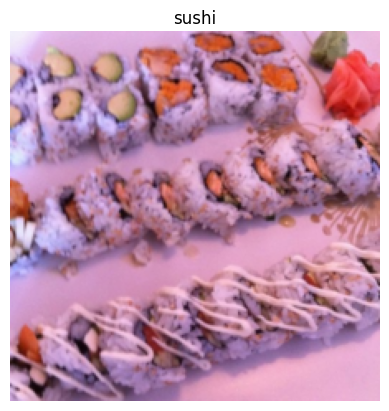

In [ ]:
# lets visualize the full image and patches of an image
image = transform(Image.open(rip)).permute(1,2,0)
plt.imshow(image)
plt.title(rip.parent.stem)
plt.axis('off')
plt.show()

### exploration, analysis and freethrows

In [ ]:
transform(Image.open(rip)).shape

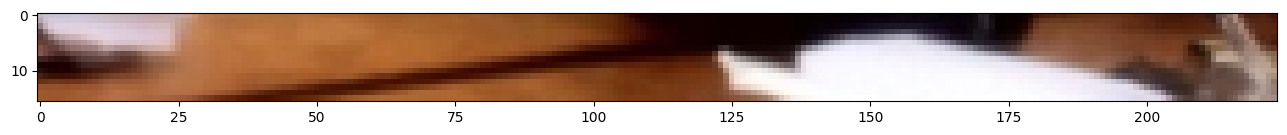

In [ ]:
image_size = 224
patch_size = 16
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(image[:patch_size,:,:]) # we want to see height only until of patch size
plt.show()

# the model would look at the cardboard part of the image. attention is paid there.

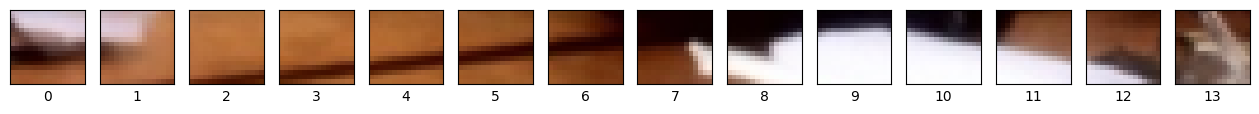

In [ ]:
image_size = 224
patch_size = 16

# make sure the image_size is divisible by the patch_size otherwise throw an error.
assert image_size % patch_size == 0

number_of_patches = image_size // patch_size # gets the quotient

fig,ax = plt.subplots(nrows=1,
                      ncols=number_of_patches,
                      figsize=(patch_size,patch_size),
                      sharex=True,
                      sharey=True)

for i,patch in enumerate(range(0,image_size,patch_size)):
  ax[i].imshow(image[:patch_size,patch:patch+patch_size,:])
  ax[i].set_xlabel(i)
  ax[i].set_xticks([])
  ax[i].set_yticks([])

plt.show()

### exploration, analysis and freethrows

In [ ]:
number_of_patches

14

In [ ]:
image_size // patch_size ## 14 is the quotient.

14

In [ ]:
for i, patch in enumerate(range(0,image_size,patch_size)):
  print(patch)

0
16
32
48
64
80
96
112
128
144
160
176
192
208


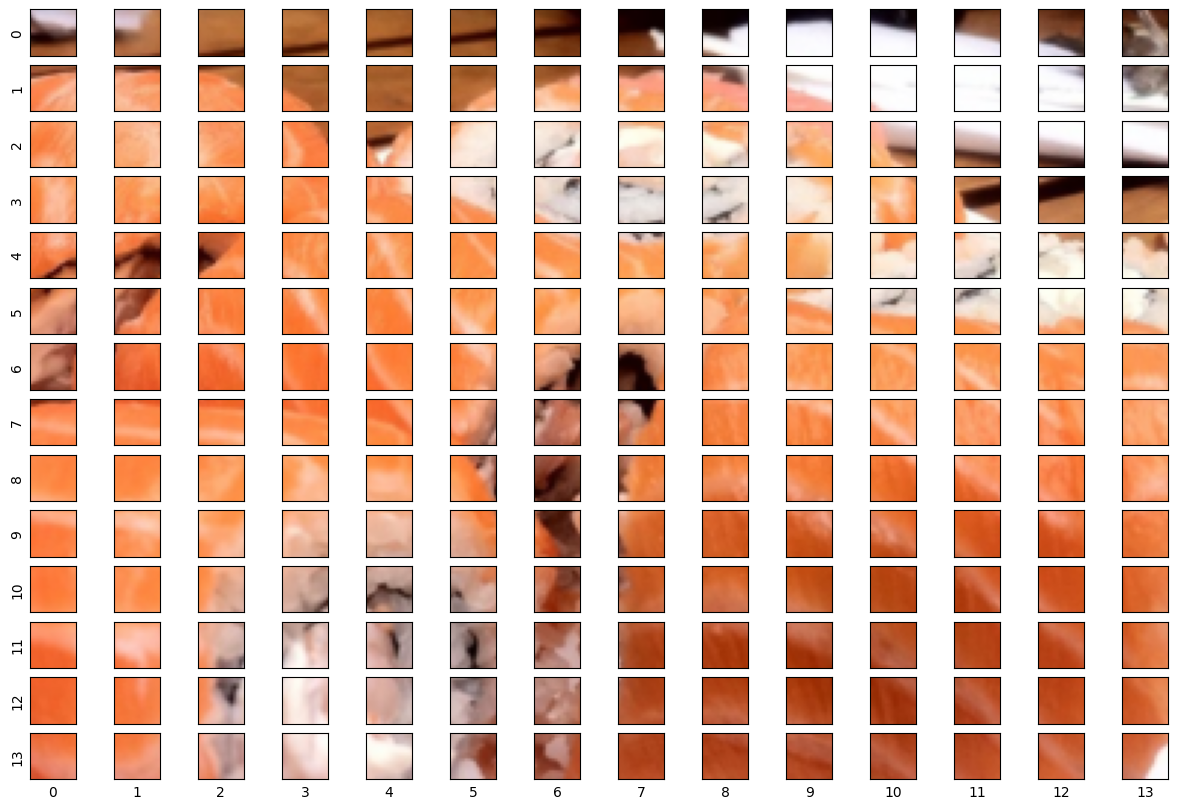

In [ ]:
# patchifying the whole image
image_size = 224
patch_size = 16

assert image_size % patch_size == 0
number_of_patches = image_size // patch_size

fig,ax = plt.subplots(nrows=number_of_patches,
                      ncols=number_of_patches,
                      figsize=(15,10),
                      sharex=True,
                      sharey=True)

for i,height_patch in enumerate(range(0,image_size,patch_size)):
  for j,width_patch in enumerate(range(0,image_size,patch_size)):
    ax[i,j].imshow(image[height_patch:height_patch+patch_size,
                               width_patch:width_patch+patch_size,
                               :]) # the last colon is for color channels

    ax[i,j].set_ylabel(i)
    ax[i,j].set_xlabel(j)
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])
    ax[i,j].label_outer()

plt.show()

# creating Embedding layers(learnable matrix)

In fact, the authors of the ViT paper mention in section 3.1 that the patch embedding is achievable with a convolutional neural network (CNN):

  * excerpt from paper: Hybrid Architecture. As an alternative to raw image patches, the input sequence can be formed from feature maps of a CNN (LeCun et al., 1989). In this hybrid model, the patch embedding projection $\mathbf{E}$ (Eq. 1) is applied to patches extracted from a CNN feature map. As a special case, the patches can have spatial size $1 \times 1$, which means that the input sequence is obtained by **simply flattening the spatial dimensions of the feature map and projecting to the Transformer dimension**. The classification input embedding and position embeddings are added as described above.


## what is a feature map?
![fsfsfd](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-patch-embedding-animation.gif)

  * feature map is weight and activations produced by the conv2d layer when hovering over an image.


## connection between conv2D and patchifying the images:
  Remember our ideal input and output shapes for the patch embedding layer?
- Input: The image starts as 2D with size $H \times W \times C$.
个 Back to top
- Output: The image gets converted to a 1D sequence of flattened 2D patches with size $N \times\left(P^2 \cdot C\right)$.

Or for an image size of 224 and patch size of 16:
- Input (2D image): $(224,224,3)$-> (height, width, color channels)
- Output (flattened 2D patches): $(196,768)$-> (number of patches, embedding dimension)

We can recreate these with:
- torch.nn. Conv2d( ) for turning our image into patches of CNN feature maps.
- torch.nn.Flatten( ) for flattening the spatial dimensions of the feature map.




In [ ]:
# code it
Conv2d = torch.nn.Conv2d(in_channels=3,#number of color channels
                         out_channels=768,#embeddding hidden layer D(N^2 * C) which is also known as embedding_dim
                         kernel_size=patch_size,
                         stride=patch_size,
                         padding=0)
Conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [ ]:
# pass an image to the conv2d layer
image = transform(Image.open(rip))
conv_image = Conv2d(image.unsqueeze(dim=0)) # extra dimension for batch

print('shape of the original image: {}'.format(image.shape))
print('shape of the Conv2d passed image: {}'.format(conv_image.shape))
print('1:Batch_size,\t 768:embedding_dimension,\t 14:height,\t 14:width')

shape of the original image: torch.Size([3, 224, 224])
shape of the Conv2d passed image: torch.Size([1, 768, 14, 14])
1:Batch_size,	 768:embedding_dimension,	 14:height,	 14:width


### exploration, analysis and freethrows

In [ ]:
embedding_layer_output_shape

(196, 768)

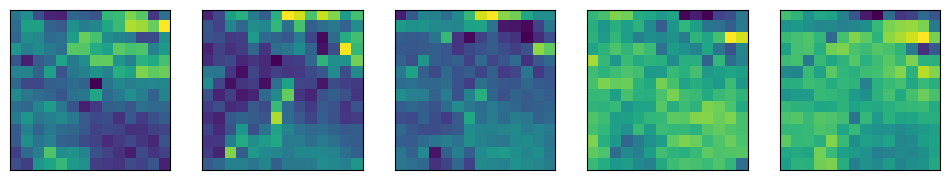

In [ ]:
# create 5 random convolutional feature maps;

"""
Notice how the feature maps all kind of represent the original image,
after visualizing a few more you can start to see the different major outlines and
some major features.

The important thing to note is that these features may change over time as the
neural network learns.

And because of these, these feature maps can be considered a learnable embedding of our image.

"""

random_indexes = np.random.choice(range(0,768),5)

fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(12,5))

for i,random_index in enumerate(random_indexes):
  conv_layer_feature_map = conv_image[:,random_index,:,:] # batch index,feature_map index,height index, width index
  ax[i].imshow(conv_layer_feature_map.squeeze().detach().numpy())
  ax[i].set(xticklabels=[],yticklabels=[],xticks=[],yticks=[])

plt.show()

### exploration, analysis and freethrows

In [ ]:
# single feature_map
conv_image = Conv2d(image.unsqueeze(dim=0))
conv_image[:,0,:,:] # this is the feature map for the first index

# feature map is a learnable embedding since it comes with a gradient function in it.

tensor([[[-0.1934, -0.1710, -0.1705, -0.0576, -0.1394, -0.2216, -0.1971,
          -0.3356, -0.5176, -0.7041, -0.5273, -0.6313, -0.3231, -0.3235],
         [-0.4281, -0.4911, -0.4567, -0.2974, -0.2566, -0.3432, -0.5567,
          -0.5342, -0.4690, -0.4113, -0.4068, -0.4578, -0.3796, -0.4988],
         [-0.4228, -0.4076, -0.3908, -0.3338, -0.5103, -0.5237, -0.2934,
          -0.4551, -0.4208, -0.3963, -0.1536, -0.0672, -0.0130, -0.1326],
         [-0.3728, -0.3826, -0.2897, -0.3550, -0.4691, -0.3640, -0.2409,
          -0.4399, -0.3569, -0.4108, -0.4016, -0.2254, -0.3869, -0.4043],
         [-0.2036, -0.1105, -0.4530, -0.4284, -0.3679, -0.3749, -0.3913,
          -0.3361, -0.3330, -0.4005, -0.4982, -0.3951, -0.5545, -0.5180],
         [-0.4782, -0.3279, -0.3704, -0.3393, -0.3974, -0.3517, -0.3744,
          -0.3542, -0.3946, -0.4424, -0.3363, -0.4630, -0.2947, -0.3251],
         [-0.1297, -0.3301, -0.2963, -0.3680, -0.3034, -0.3063,  0.0507,
          -0.2770, -0.3898, -0.3892, -0.3706,

In [ ]:
torch.squeeze(conv_image[:,0,:,:]).shape

# these are in 2d shapes

torch.Size([14, 14])

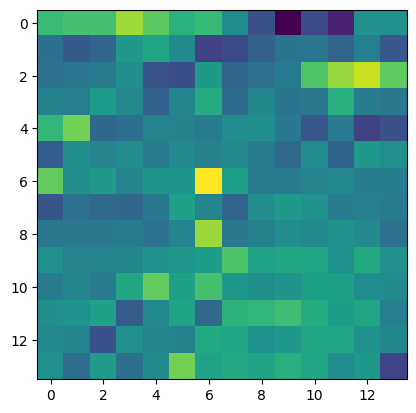

In [ ]:
plt.imshow(torch.squeeze(conv_image[:,0,:,:]).detach().numpy());

# flattening the patch_embeddings with torch.nn.Flatten()

* We've turned our image into patch embeddings but they're still in 2D format.

* How do we get them into the desired output shape of the patch embedding layer of the ViT model?
- Desired output (1D sequence of flattened 2D patches): $(196,768)$-> (number of patches, embedding dimension) -> $N \times\left(P^2 \cdot C\right)$

## reading from the paper:
* Reading back through section 3.1 of the ViT paper it says (bold mine):
* **excerpt from paper**: As a special case, the patches can have spatial size $1 \times 1$, which means that the `input sequence is obtained by simply flattening the spatial dimensions of the feature map and projecting to the Transformer dimension`.

## plan:
How about torch.nn.Flatten()?

* But we don't want to flatten the whole tensor, we only want to flatten the "spatial dimensions of the feature map".

* Which in our case is the `feature_map_height` and `feature_map_width`

* So how about we create a torch.nn.Flatten( ) layer to only flatten those dimensions, we can use the start_dim and end_dim parameters to set that up?



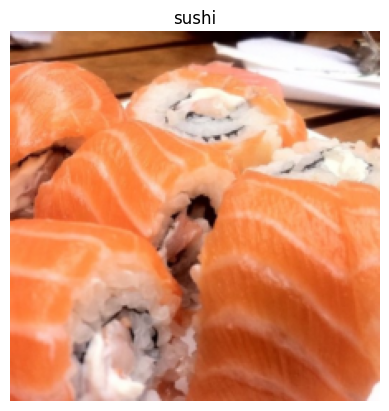

Shape of the original image: torch.Size([3, 224, 224])
shape of the conv_image: torch.Size([1, 768, 14, 14])
shape of the flattened conv_image: torch.Size([1, 768, 196])


In [ ]:
# code:
"""
1. take an image
2. put it through the Conv2d layer
3. flatten it by setting the dimensions
"""
# visualize the transformed image and display its shape
plt.imshow(image.permute(1,2,0))
plt.title(rip.parent.stem)
plt.axis('off')
plt.show()
print("Shape of the original image: {}".format(image.shape))

# put it through the Conv2d layer and display its shape then
conv_image = Conv2d(torch.unsqueeze(image,dim=0)) #adding batch dimension for conv2d to work
print("shape of the conv_image: {}".format(conv_image.shape))

# flatten the image using torch.nn.Flatten() and display its shape then
Flatten = torch.nn.Flatten(start_dim=2,end_dim=3) # flatten only height and width
flattened_conv_image = Flatten(conv_image)
print("shape of the flattened conv_image: {}".format(flattened_conv_image.shape))

# Arrange the dimensions using permute

* Desired flattened 2d patch has shape: (196,768) -> N,(p^2*c)
* curretn flattened 2d patch has shape: (1,768,196)
* we can fix this using torch.Tensor.permute()

In [ ]:
flattened_conv_image_reshaped = flattened_conv_image.permute(0,2,1)
print("shape of this is: {}".format(flattened_conv_image_reshaped.shape))

shape of this is: torch.Size([1, 196, 768])


### exploration, analysis and freethrows

In [ ]:
single_flattened_feature_map = flattened_conv_image_reshaped[:,:,0] # index: batch, patch_size, embedding index
single_flattened_feature_map,single_flattened_feature_map.shape

(tensor([[-0.1934, -0.1710, -0.1705, -0.0576, -0.1394, -0.2216, -0.1971, -0.3356,
          -0.5176, -0.7041, -0.5273, -0.6313, -0.3231, -0.3235, -0.4281, -0.4911,
          -0.4567, -0.2974, -0.2566, -0.3432, -0.5567, -0.5342, -0.4690, -0.4113,
          -0.4068, -0.4578, -0.3796, -0.4988, -0.4228, -0.4076, -0.3908, -0.3338,
          -0.5103, -0.5237, -0.2934, -0.4551, -0.4208, -0.3963, -0.1536, -0.0672,
          -0.0130, -0.1326, -0.3728, -0.3826, -0.2897, -0.3550, -0.4691, -0.3640,
          -0.2409, -0.4399, -0.3569, -0.4108, -0.4016, -0.2254, -0.3869, -0.4043,
          -0.2036, -0.1105, -0.4530, -0.4284, -0.3679, -0.3749, -0.3913, -0.3361,
          -0.3330, -0.4005, -0.4982, -0.3951, -0.5545, -0.5180, -0.4782, -0.3279,
          -0.3704, -0.3393, -0.3974, -0.3517, -0.3744, -0.3542, -0.3946, -0.4424,
          -0.3363, -0.4630, -0.2947, -0.3251, -0.1297, -0.3301, -0.2963, -0.3680,
          -0.3034, -0.3063,  0.0507, -0.2770, -0.3898, -0.3892, -0.3706, -0.3546,
          -0.384

# Turning VIT patch embedding layer into a pytorch module using class

* we are going to convert everything we've done so far above into a single pytorch layer that we can call anytime we are in need of it.


In [ ]:
class PatchEmbedding(torch.nn.Module):
  def __init__(self,
               color_channels=3,
               embedding_dim=768,
               patch_size=16):
    super().__init__()

    self.patcher = torch.nn.Conv2d(in_channels=color_channels,
                                   out_channels=embedding_dim,
                                   kernel_size=patch_size,
                                   stride=patch_size,
                                   padding=0)
    self.flatten = torch.nn.Flatten(start_dim=2,end_dim=3) # flatten only the height and width

  # execute it all in forward call
  def forward(self,input):
    image_size = input.shape[-1]

    assert image_size % patch_size == 0
    patched_image = self.patcher(input)
    flattened_image = self.flatten(patched_image)

    return flattened_image.permute(0,2,1) # just like in the steps above.

In [ ]:
patchify = PatchEmbedding(color_channels=3,
                          embedding_dim=768,
                          patch_size=16)

batched_image = torch.unsqueeze(image,dim=0)
print("shape of the original image : {}".format(batched_image.shape))
print("shape of the patchified image : {}".format(patchify(batched_image).shape))


shape of the original image : torch.Size([1, 3, 224, 224])
shape of the patchified image : torch.Size([1, 196, 768])


# creating a learnable class token embedding

excerpt from the paper:
* Reading the second paragraph of section 3.1 from the ViT paper.
* we see the following description:  
Similar to BERT's [ class ] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4).  
* Note: BERT (Bidirectional Encoder Representations from Transformers) is one of the original machine learning research papers to use the Transformer architecture to achieve outstanding results on natural language processing (NLP) tasks and is where the idea of having a [ class ] token at the start of a sequence originated, class being a description for the "classification" class the sequence belonged to.


## goal:
* add class_token to the patch embedding

-pseudocode:
```python
# class_token with patch_embedding
patch_embedding = [image_patch_1, image_patch_2, image_patch_3...]
class_token = learnable_embedding
patch_embedding_with_class_token = torch.cat((class_token, patch_embedding), dim=1)
Notice the concatenation (torch.cat()) happens on dim=1 (the number_of_patches dimension).
```

![sfsdf](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-prepending-the-learnable-class-token.png)

In [ ]:
# code
patchified_image = patchify(torch.unsqueeze(image,dim=0))
batch_size = patchified_image.shape[0] # which is 1
embedding_dim = patchified_image.shape[-1] # which is 768
class_token = torch.nn.Parameter(torch.ones(batch_size,1,embedding_dim),
                                 requires_grad = True) # learnable

patchified_image.shape, class_token.shape

(torch.Size([1, 196, 768]), torch.Size([1, 1, 768]))

In [ ]:
# concatenate the class token with patchfied image on the 1st dimension(dim=1)
class_embedded_patchified_image = torch.cat((class_token,patchified_image),dim=1)
class_embedded_patchified_image, class_embedded_patchified_image.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.3664,  0.0465,  0.6413,  ..., -0.4465, -0.1703, -0.4837],
          [-0.5569, -0.0657,  0.6980,  ..., -0.5670, -0.1723, -0.5192],
          ...,
          [-0.5101, -0.1844,  0.5217,  ..., -0.4719, -0.0666, -0.2785],
          [-0.5882, -0.1825,  0.6149,  ..., -0.5208, -0.0792, -0.3938],
          [-0.5027, -0.0286,  0.8718,  ..., -0.6790, -0.1441, -0.4523]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

# creating the postion embedding:

* Well, we've got the class token embedding and the patch embedding, now how might we create the position embedding?  
  
* Or $\mathbf{E}_{\text {pos }}$ from equation 1 where $E$ stands for "embedding".


![sfsf](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-the-position-embeddings.png)

* excerpt from paper:
Let's find out more by reading section 3.1 of the ViT paper (bold mine):  
Position embeddings are added to the patch embeddings to retain positional information. We use `standard learnable 1D position embeddings`, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.


* **This positional information can be important when considering what's in an image (without positional information an a flattened sequence could be seen as having no order and thus no patch relates to any other patch)**.
-------------------

## Equation:
$$ E_{pos} \in R^{(n+1) * D} $$
where,
* E_pos is embedding patch positions.
* R stands for real number system.
* n stands for number_of_patches which is incremented by 1.
* D stands for embedding dim

![fsdfsdf](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-patch-embeddings-with-learnable-class-token-and-position-embeddings.png)




In [ ]:
# lets create Epos
patch_size = 16
number_of_patches = int(height*width / patch_size**2)
batch_size = 1
embedded_dim = 768

position_embedding = torch.nn.Parameter(torch.ones(batch_size,
                                                   number_of_patches+1, # extra one is added to match with class embedded image
                                                   embedded_dim),
                                                   requires_grad=True) # made learnable
position_embedding,position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [ ]:
# addin the class and position embedding together
class_and_position_embedding = class_embedded_patchified_image + position_embedding
class_and_position_embedding, class_and_position_embedding.shape

(tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [0.6336, 1.0465, 1.6413,  ..., 0.5535, 0.8297, 0.5163],
          [0.4431, 0.9343, 1.6980,  ..., 0.4330, 0.8277, 0.4808],
          ...,
          [0.4899, 0.8156, 1.5217,  ..., 0.5281, 0.9334, 0.7215],
          [0.4118, 0.8175, 1.6149,  ..., 0.4792, 0.9208, 0.6062],
          [0.4973, 0.9714, 1.8718,  ..., 0.3210, 0.8559, 0.5477]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

# putting it all together:

$\mathbf{z}_{0}=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, \quad \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}$

In [ ]:
patch_size = 16
batched_image = torch.unsqueeze(image,dim=0)
height = 224
weight = 224
number_of_patches =  int(height*weight / patch_size**2)
color_channels = 3
embedding_dim = patch_size**2 * color_channels

print("original image shape: {}".format(image.shape))
print("batched image shape: {}".format(batched_image.shape))

patchify = PatchEmbedding(color_channels=color_channels,
                          embedding_dim=embedding_dim,
                          patch_size = patch_size)

patchified_image = patchify(batched_image)
print("Patchified image shape: {}".format(patchified_image.shape))

class_embedding = torch.nn.Parameter(torch.ones(batch_size,1,embedding_dim),
                                     requires_grad=True)
print("class embedding shape: {}".format(class_embedding.shape))

class_patch_embedding = torch.cat((patchified_image,class_embedding),dim=1)
print("class patch embedding shape: {}".format(class_patch_embedding.shape))

position_embedding = torch.nn.Parameter(torch.ones(batch_size,
                                                   number_of_patches+1,
                                                   embedding_dim),
                                        requires_grad=True)
print("position embedding shape: {}".format(position_embedding.shape))

class_patch_position_embedding = class_patch_embedding + position_embedding
print("class patch position embedding shape: {}".format(class_patch_position_embedding.shape))

original image shape: torch.Size([3, 224, 224])
batched image shape: torch.Size([1, 3, 224, 224])
Patchified image shape: torch.Size([1, 196, 768])
class embedding shape: torch.Size([1, 1, 768])
class patch embedding shape: torch.Size([1, 197, 768])
position embedding shape: torch.Size([1, 197, 768])
class patch position embedding shape: torch.Size([1, 197, 768])


In [ ]:
number_of_patches,embedding_dim

(196, 768)

# Equation2: Multi Head Attention:

![fsfd](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-2-msa-block-mapped-to-equation.png)


## equation 2:
$$ z^{'}_{l} = MSA(LN(z_{l-1})) + z_{l-1} \quad  l = 1...L $$

## in built pytorch functions to satisfy the equation:
* torch.nn.MultiHeadAttention()
* torch.nn.LayerNorm()


## what does the LayerNorm do?
* it normalizes the data.
* it helps to train the data.
* it helps to generalize the model to unseen data.
* what does it mean to normalize? imagine you are climbing a staircase, if each step's height and width vary from each other then you would difficult time climbing versus having all of the steps in same height and width. Just like in that example scenario, normalization ensures to keep the distribution of the data to have same mean and standard deviation helping the model to navigate faster in the world of that data.


## Multi-head self attention layer:
* The power of the self-attention and multi-head attention (self-attention applied multiple times) were revealed in the form of the original Transformer architecture introduced in the Attention is all you need research paper.

* Originally designed for text inputs, the original self-attention mechanism takes a sequence of words and then calculates which word should pay more "attention" to another word.

* In other words, in the sentence "the dog jumped over the fence", perhaps the word "dog" relates strongly to "jumped" and "fence".

* This is simplified but the premise remains for images.

* Since our input is a sequence of image patches rather than words, self-attention and in turn multi-head attention will calculate which patch of an image is most related to another patch, eventually forming a learned representation of an image.

* But what's most important is that the layer does this on it's own given the data (we don't tell it what patterns to learn).

* And if the learned representation the layers form using MSA are good, we'll see the results in our model's performance.

* There are many resources online to learn more about the Transformer architeture and attention mechanism online such as Jay Alammar's wonderfully Illustrated Transformer post and Illustrated Attention post.

![sfsfs](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-2-appendix-A.png)

## multihead self attention layer:
We can implement the MSA layer in PyTorch with torch.nn.MultiheadAttention( ) with the parameters:  
- embed_dim - the embedding dimension from Table 1 (Hidden size $D$ ).  
- num_heads - how many attention heads to use (this is where the term "multihead" comes from), this value is also in Table 1 (Heads).  
- dropout - whether or not to apply dropout to the attention layer (according to Appendix B.1, dropout isn't used after the qkv-projections).  
- batch_first - does our batch dimension come first? (yes it does).



In [ ]:
# code: getting the equation 2 ready
class MSA_Block(torch.nn.Module):
  # MSA stands for Multi Head Self Attention Block
  def __init__(self,
               num_heads = 12, # from the research document
               embedding_dim = 768,
               dropout = 0):
    super().__init__()

    # create the layer norm
    self.layer_norm = torch.nn.LayerNorm(normalized_shape=embedding_dim)

    # create the multi head self attention layer
    self.multihead_attention = torch.nn.MultiheadAttention(embed_dim=embedding_dim,
                                                            num_heads=num_heads,
                                                            dropout=dropout,
                                                            batch_first=True)

  def forward(self,input):
    input = self.layer_norm(input)
    attention_output, _ = self.multihead_attention(query=input,
                                                   key=input,
                                                   value=input,
                                                   need_weights=False)

    return attention_output

In [ ]:
msa = MSA_Block(embedding_dim=768,num_heads=12)

class_patch_position_embedding_through_msa = msa(class_patch_position_embedding)
print("original class patch position embedding: {}".format(class_patch_position_embedding.shape))
print("cppe through msa: {}".format(class_patch_position_embedding_through_msa.shape))

original class patch position embedding: torch.Size([1, 197, 768])
cppe through msa: torch.Size([1, 197, 768])


In [ ]:
class_patch_position_embedding

tensor([[[1.5297, 0.3729, 0.9879,  ..., 1.4197, 0.9468, 1.2879],
         [1.5330, 0.2527, 1.2343,  ..., 1.2863, 1.1225, 1.3842],
         [1.5891, 0.2896, 1.1877,  ..., 1.0713, 1.1626, 1.2688],
         ...,
         [1.6885, 0.2426, 1.2361,  ..., 1.0788, 1.1086, 1.3376],
         [2.0464, 0.2637, 1.2229,  ..., 1.3255, 1.1746, 1.4155],
         [2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000]]],
       grad_fn=<AddBackward0>)

In [ ]:
class_patch_position_embedding_through_msa

# Equation 3: Multi Layer perceptron:
$$ z_l = MLP(LN(z^{'}_{l})) + z^{'}_{l} \quad l={1.....L} $$

![sfsfs](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-equation-3-annotated.png)

* the + at the end indicates the skip/residual connection.

* excerpt from the paper: Another sneaky detail about the MLP block doesn't appear until Appendix B.1 (Training):

* Table 3 summarizes our training setups for our different models. ...Dropout, when used, is applied after every dense layer except for the the qkv-projections and directly after adding positional- to patch embeddings.

*  the structure of our MLP layer is going to be: LinearNorm -> LinearLayer -> Non-LinearLayer -> Dropout -> LinearLayer -> Dropout.

* the non_linear layer they used in the paper seems to GELU which stands for Guassian Error Linear Units.

In [ ]:
# creating the MLP object
class MLP_Block(torch.nn.Module):
  def __init__(self,
               embedding_dim=768,
               mlp_size=3072, # according to the document.
               dropout=0.1): # according to the document

               super().__init__()

               self.layer_norm = torch.nn.LayerNorm(normalized_shape=embedding_dim)

               self.mlp = torch.nn.Sequential(
                   torch.nn.Linear(in_features=embedding_dim,
                                   out_features=mlp_size),
                   torch.nn.GELU(), # it is used in the document
                   torch.nn.Dropout(p=dropout),
                   torch.nn.Linear(in_features=mlp_size,
                                   out_features=embedding_dim),
                   torch.nn.Dropout(p=dropout)
               )

  def forward(self,input):
    input = self.layer_norm(input)
    mlp_output = self.mlp(input)
    return mlp_output


In [ ]:
# lets test this out
mlp = MLP_Block(embedding_dim=768,mlp_size=3072,dropout=0.1)
cppe_t_msa_mlp = mlp(class_patch_position_embedding_through_msa)

print("Class Patch position embedding through MSA: {}".format(class_patch_position_embedding_through_msa.shape))
print("class patch position embedding through MSA and MLP: {}".format(cppe_t_msa_mlp.shape))

Class Patch position embedding through MSA: torch.Size([1, 197, 768])
class patch position embedding through MSA and MLP: torch.Size([1, 197, 768])


In [ ]:
class_patch_position_embedding_through_msa

tensor([[[-0.6916, -0.0585, -0.3383,  ..., -0.2748,  0.0820,  0.2750],
         [-0.6935, -0.0589, -0.3398,  ..., -0.2747,  0.0851,  0.2805],
         [-0.6955, -0.0600, -0.3398,  ..., -0.2757,  0.0854,  0.2825],
         ...,
         [-0.6979, -0.0587, -0.3406,  ..., -0.2753,  0.0859,  0.2858],
         [-0.6968, -0.0611, -0.3409,  ..., -0.2734,  0.0850,  0.2852],
         [-0.6937, -0.0520, -0.3364,  ..., -0.2831,  0.0802,  0.2853]]],
       grad_fn=<TransposeBackward0>)

In [ ]:
cppe_t_msa_mlp

tensor([[[ 0.2193,  0.1723, -0.3745,  ...,  0.1252, -0.2650, -0.0555],
         [ 0.0000,  0.3344, -0.3576,  ...,  0.1168, -0.0000, -0.0694],
         [ 0.0000,  0.2449, -0.4011,  ...,  0.0523, -0.1791,  0.0039],
         ...,
         [ 0.1132,  0.0318, -0.4024,  ...,  0.0100, -0.2724,  0.0220],
         [ 0.1738,  0.0000, -0.3947,  ..., -0.0380, -0.0000,  0.0576],
         [ 0.2585,  0.1416, -0.3750,  ...,  0.0000, -0.2500,  0.0671]]],
       grad_fn=<MulBackward0>)

# create the Transformer Encoder: combine the eqution 2 and 3.

* in deep learning the term `encoder` refers to the stack of layers that convert an input into a numerical representation of it.
* In our case the encoder is the MSA and MLP blocks
* but one more thing is missing. residual layers aka skip connections.
* excerpt from the VIT research paper: The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).
* according to the VIT paper residual connection means passing the input of the MSA block is added back to the output of the MSA block before being passed to the MLP block.
*  `input -> MSA block -> [MSA_block_output + input] -> MLP block -> [MLP_block_output + MSA_block_output + input ] -> .....`
* one of the main advantages of Residual connection is they prevent the weights or gradient updates from getting too small which in turn would allow for deeper network with deeper learnings about the data.

* so conclusion is creating a `residual block` is all about `adding the input to the output`.

![sfsf](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-transformer-encoder-highlighted.png)




In [ ]:
class TransformerEncoderBlock(torch.nn.Module):
  def __init__(self,
              embedding_dim=768,
              mlp_size=3072,
              msa_dropout=0,
              mlp_dropout=0.1,
              num_heads=12):
    super().__init__()

    # instantiating the MSA block
    self.msa = MSA_Block(num_heads=num_heads,
                    embedding_dim=embedding_dim,
                    dropout=msa_dropout)

    # instantiating the MLP block
    self.mlp = MLP_Block(embedding_dim=embedding_dim,
                    mlp_size=mlp_size,
                    dropout=mlp_dropout)

  def forward(self,input):

    # creating the residual connection: adding the input to the output
    input = self.msa(input) + input

    input = self.mlp(input) + input

    return input


In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary
transformer_encoder_block = TransformerEncoderBlock()

summary(model=transformer_encoder_block,
        input_size=[1,197,768],
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)       [1, 197, 768]        [1, 197, 768]        --                   True
├─MSA_Block (msa)                                       [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attention)         --                   [1, 197, 768]        2,362,368            True
├─MLP_Block (mlp)                                       [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                                 [1, 197, 768]        [1, 197, 768]        --                   True
│  

# in-built transformer encoder layer:

* this would save us a lot of time: we don't have to create the equation 2 and equation 3 at all!!! everything is built-in
* it could be efficient in performance than our manually created transformer.

In [ ]:
torch_transformer_encoder_layer = \
torch.nn.TransformerEncoderLayer( d_model=768,# for embedding_dim
                                  nhead=12,#for num_heads
                                  dim_feedforward=3072,#for hidden layer units in mlp
                                  dropout=0.1,# for dropping out the neurons in mlp
                                  activation='gelu',#for non-linear activation in mlp
                                  norm_first=True,#for using LayerNorm between layers in mlp
                                  batch_first=True)
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

# putting it all together to create our first ViT model:

* Finally, since the ViT architecture uses several Transformer Layers stacked on top of each for the full architecture (Table 1 shows 12 Layers in the case of ViT-Base), you can do this with torch.nn.TransformerEncoder(encoder_layer, num_layers) where:

1. encoder_layer - The target Transformer Encoder layer created with torch.nn.TransformerEncoderLayer().
2. num_layers - The number of Transformer Encoder layers to stack together.

In [ ]:
class Vit(torch.nn.Module):
  def __init__(self,
               image_size=224,
               color_channels=3,
               patch_size=16,
               attention_dropout=0,
               embedding_dropout=0.1,
               mlp_size=3072,
               mlp_dropout=0.1,
               num_heads=12,
               num_classes=1000,
               num_transformer_layers=12
               ):
    super().__init__()

    # creating the embedding_dim and num_patches
    assert image_size % patch_size == 0
    self.embedding_dim = patch_size**2 * color_channels
    self.num_patches = (image_size*image_size) // patch_size**2

    # class_embedding, position_embedding and patch_embedding
    self.class_embedding = torch.nn.Parameter(torch.randn(1,1,self.embedding_dim),
                                               requires_grad=True)

    self.position_embedding = torch.nn.Parameter(torch.randn(1,self.num_patches+1,
                                                             self.embedding_dim),
                                                 requires_grad=True)

    self.patch_embedding = PatchEmbedding(color_channels=color_channels,
                                          embedding_dim=self.embedding_dim,
                                          patch_size=patch_size)

    # create embedding_dropout to dropout a % of neurons to regularize the network for performance and efficiency
    self.embedding_dropout = torch.nn.Dropout(p=embedding_dropout)

    # create transformer_encoders
    # note: * means all.
    self.transformer_encoders = torch.nn.Sequential(
        *[torch_transformer_encoder_layer for _ in range(num_transformer_layers)]
        )

    # create the classifier layer:
    self.classifier = torch.nn.Sequential(
        torch.nn.LayerNorm(normalized_shape=self.embedding_dim),
        torch.nn.Linear(in_features=self.embedding_dim,
                        out_features=num_classes)

    )

  def forward(self,input):

    batch_size = input.shape[0]

    # creating the patch_embedding with class_tokens
    class_tokens = self.class_embedding.expand(batch_size,-1,-1)
    input = self.patch_embedding(input)
    input = torch.cat((class_tokens,input),dim=1)

    # adding the input with position embedding layer
    input = self.position_embedding + input

    # dropping out some neurons
    input = self.embedding_dropout(input)

    # passing the input through the transformer_encoders
    for transformer in self.transformer_encoders:
      input = transformer(input)

    # classifier layer(all rows and first column)
    output = self.classifier(input[:,0])

    return output






In [ ]:
# lets test it out

random_tensor = torch.randn(1,3,224,224)
vit = Vit(num_classes=len(class_names))
vit(random_tensor)

tensor([[-0.4382, -0.0069,  0.5217]], grad_fn=<AddmmBackward0>)

# training our ViT model with data:

### creating optimizer and loss function:
* excerpt from the paper: Training & Fine-tuning. We train all models, including ResNets, using Adam (Kingma & Ba, 2015 ) with  β1=0.9,β2=0.999, a batch size of 4096 and apply a high weight decay of  0.1, which we found to be useful for transfer of all models (Appendix D.1 shows that, in contrast to common practices, Adam works slightly better than SGD for ResNets in our setting).



In [ ]:
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=0.003,#according to the paper
                             betas=(0.9,0.999),#according to the paper
                             weight_decay=0.1#according to the paper
                             )
loss_fn = torch.nn.CrossEntropyLoss()

from going_modular.going_modular import engine

"""
model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device
"""
# setting random seed for getting reproducible results
torch.random.manual_seed(42)
torch.cuda.manual_seed(42)

# setting the device agnostic code.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

result = engine.train(model=vit,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=10,
                      device=device)



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6357 | train_acc: 0.4219 | test_loss: 3.6785 | test_acc: 0.2604
Epoch: 2 | train_loss: 2.7054 | train_acc: 0.2734 | test_loss: 2.0335 | test_acc: 0.2396
Epoch: 3 | train_loss: 1.4344 | train_acc: 0.3047 | test_loss: 1.0640 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2318 | train_acc: 0.2734 | test_loss: 1.7953 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.2988 | train_acc: 0.3008 | test_loss: 1.5243 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.2330 | train_acc: 0.2969 | test_loss: 1.3860 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.2964 | train_acc: 0.2617 | test_loss: 1.5286 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.2126 | train_acc: 0.3086 | test_loss: 1.1887 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1374 | train_acc: 0.4102 | test_loss: 1.3885 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.3630 | train_acc: 0.3008 | test_loss: 1.6299 | test_acc: 0.2604


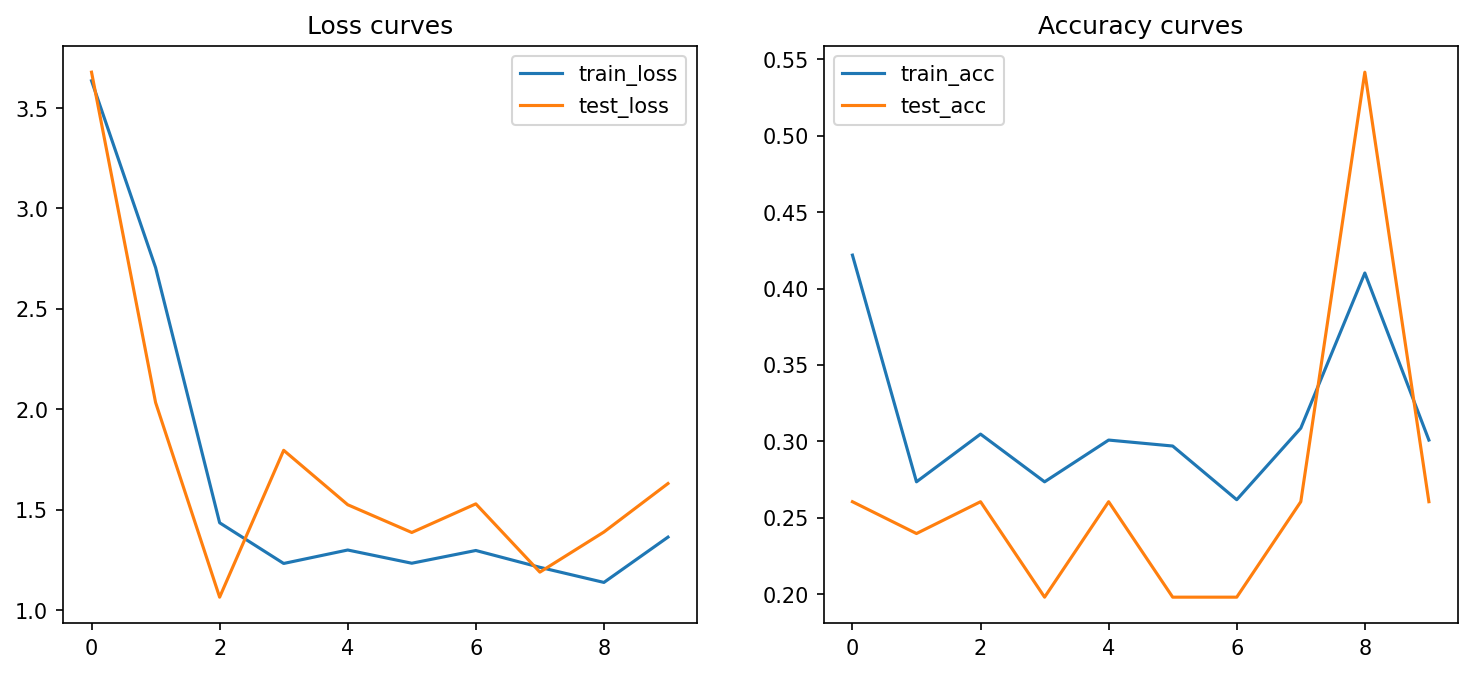

In [ ]:
fig,ax = plt.subplots(1,2,dpi=150,figsize=(12,5))

ax[0].plot(result['train_loss'],label='train_loss')
ax[0].plot(result['test_loss'],label='test_loss')
ax[0].set_title('Loss curves')
ax[0].legend()

ax[1].plot(result['train_acc'],label='train_acc')
ax[1].plot(result['test_acc'],label='test_acc')
ax[1].set_title('Accuracy curves')
ax[1].legend()

plt.show()

# training our data with a pretrained ViT model:

* pretrained models are trained with a lot of data and for a longer time(even for days and weeks) so their performance will surpass any manually made custom models that were made on the fly with severe data and time constraints like ours, so why not leverage the best?

## growing trend of democratizing the source code and models:
* So having a pretrained model available through resources like torchvision.models, the timm (Torch Image Models) library, the HuggingFace Hub or even from the authors of the papers themselves (there's a growing trend for machine learning researchers to release the code and pretrained models from their research papers, I'm a big fan of this trend, many of these resources can be found on www.Paperswithcode.com).

In [ ]:
weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit_model = torchvision.models.vit_b_16(weights=weights)

# lets transform
pretrained_vit_transform = torchvision.models.ViT_B_16_Weights.DEFAULT.transforms()
# lets freeze the baselayers
for parameter in pretrained_vit_model.parameters():
  parameter.requires_grad = False

# view the model to fine-tune it to our custom Image data
pretrained_vit_model

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 74.0MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

### Notes:
* But the number of trainable parameters for pretrained_vit is much, much lower than our custom vit at only 2,307 compared to 85,800,963 (in our custom vit, since we're training from scratch, all parameters are trainable).

* This means the pretrained model should train a lot faster, we could potentially even use a larger batch size since less parameter updates are going to be taking up memory.

In [ ]:
# fine-tune the final layer to our data
pretrained_vit_model.heads = torch.nn.Linear(in_features=768,out_features=len(class_names)).to(device)

# lets create new train and test dataloaders with updated transforms
"""
train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
"""
from going_modular.going_modular import data_setup
train_dataloader,test_dataloader,class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=pretrained_vit_transform,
    batch_size=32,
    num_workers=os.cpu_count()
)



In [ ]:
# train the model with our data
optimizer = torch.optim.Adam(params=pretrained_vit_model.parameters(),
                             lr=0.003,
                             betas=(0.9,0.999),
                             weight_decay=0.1)

loss_fn = torch.nn.CrossEntropyLoss()

# set random seed
torch.random.manual_seed(42)
torch.cuda.manual_seed(42)

pretrained_vit_model_results = engine.train(
    model=pretrained_vit_model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4727 | train_acc: 0.8203 | test_loss: 0.2422 | test_acc: 0.8977
Epoch: 2 | train_loss: 0.1156 | train_acc: 0.9727 | test_loss: 0.1865 | test_acc: 0.9176
Epoch: 3 | train_loss: 0.0743 | train_acc: 0.9766 | test_loss: 0.2041 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.0477 | train_acc: 0.9844 | test_loss: 0.2074 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.0340 | train_acc: 0.9961 | test_loss: 0.1979 | test_acc: 0.9280
Epoch: 6 | train_loss: 0.0378 | train_acc: 0.9961 | test_loss: 0.1926 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0318 | train_acc: 1.0000 | test_loss: 0.2249 | test_acc: 0.9081
Epoch: 8 | train_loss: 0.0324 | train_acc: 1.0000 | test_loss: 0.1973 | test_acc: 0.9384
Epoch: 9 | train_loss: 0.0428 | train_acc: 1.0000 | test_loss: 0.1847 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0414 | train_acc: 1.0000 | test_loss: 0.1880 | test_acc: 0.9280


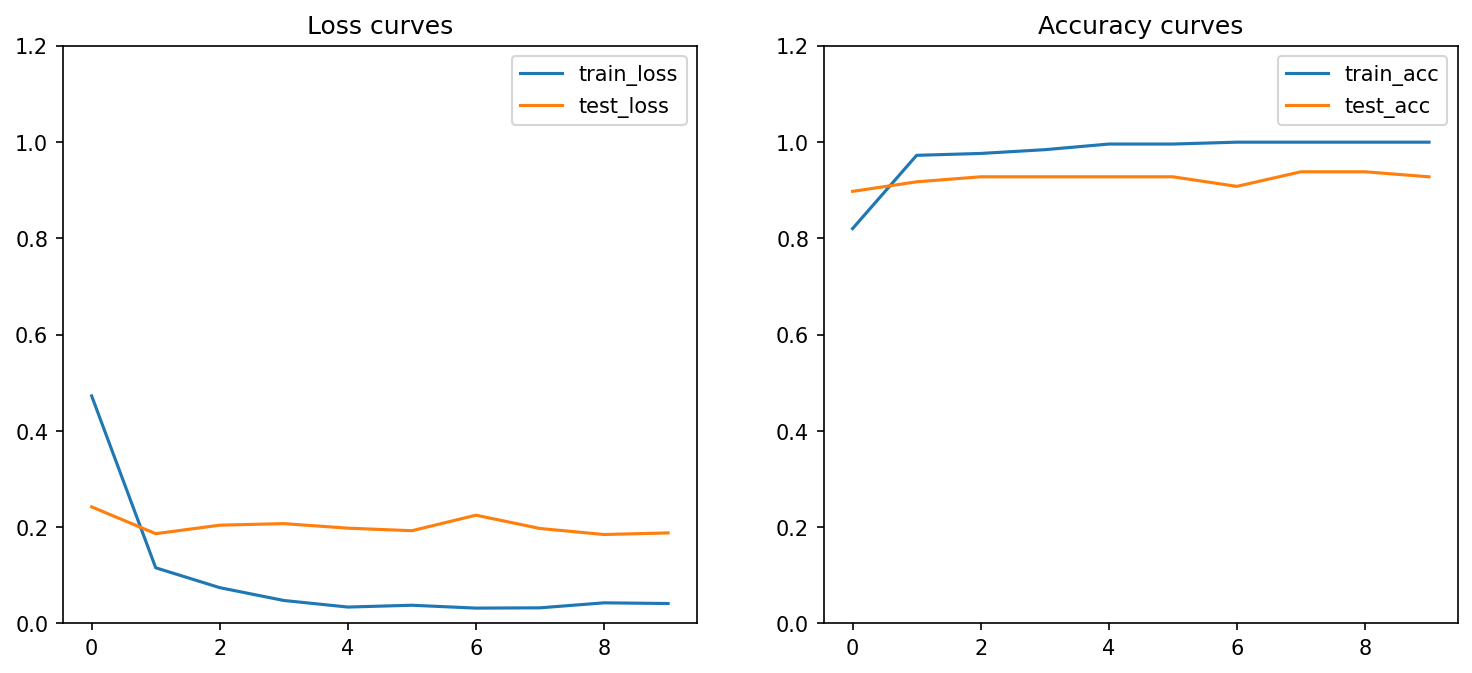

In [ ]:
# plotting the loss and accuracy curves
fig,ax = plt.subplots(1,2,dpi=150,figsize=(12,5))

ax[0].plot(pretrained_vit_model_results['train_loss'],label='train_loss')
ax[0].plot(pretrained_vit_model_results['test_loss'],label='test_loss')
ax[0].set_title('Loss curves')
ax[0].legend()
ax[0].set_ylim([0,1.2])

ax[1].plot(pretrained_vit_model_results['train_acc'],label='train_acc')
ax[1].plot(pretrained_vit_model_results['test_acc'],label='test_acc')
ax[1].set_title('Accuracy curves')
ax[1].legend()
ax[1].set_ylim([0,1.2])


plt.show()

In [ ]:
# save the model
"""
target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)
"""
def save_models(model,model_name):
  dir = Path('saved_models')
  dir.mkdir(parents=True,exist_ok=True)
  model_saved_path = 'saved_models' + model_name

  torch.save(obj=model.state_dict(),f=model_saved_path)


save_models(model=pretrained_vit_model,
            model_name='/pretrained_vit_model_10percent_image.pth')




In [ ]:
# to know the size of our model
size = Path('saved_models/pretrained_vit_model_10percent_image.pth').stat().st_size // (1024*1024)

print('Size of our pretrained model is: {} MB'.format(size))

Size of our pretrained model is: 327 MB


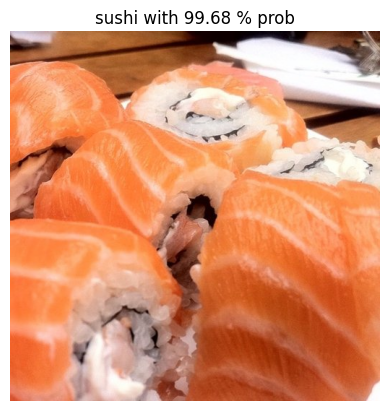

In [ ]:
# make prediction with a random image
image = Image.open(rip)

# run it through the transformation
transformed_image = pretrained_vit_transform(image).to(device)

# make pred_label and pred_prob
with torch.inference_mode():
  logit = pretrained_vit_model(transformed_image.unsqueeze(dim=0))
  pred_label = logit.argmax(dim=1)[0]
  pred_prob = torch.max(torch.softmax(logit,dim=1))

image_array = imread(rip)

plt.imshow(image_array) # this is just random image 'path' converted to numpy array and then plotted.
plt.title('{} with {:.2f} % prob'.format(class_names[pred_label],pred_prob*100))
plt.axis('off')
plt.show()


# extra curriculum:

# day 331

## ex1:

* Replicate the ViT architecture we created with in-built PyTorch transformer layers.
* You'll want to look into replacing our TransformerEncoderBlock() class with torch.nn.TransformerEncoderLayer() (these contain the same layers as our custom blocks).
* You can stack torch.nn.TransformerEncoderLayer()'s on top of each other with torch.nn.TransformerEncoder().

In [ ]:
class PatchEmbedding(torch.nn.Module):
  def __init__(self,
               color_channels=3,
               embedding_dim=768,
               patch_size=16):

    super().__init__()

    self.patcher = torch.nn.Conv2d(in_channels=color_channels,
                                   out_channels=embedding_dim,
                                   kernel_size=patch_size,
                                   stride=patch_size,
                                   padding=0)
    self.flatten = torch.nn.Flatten(start_dim=2,end_dim=3)

  def forward(self,input):
    input = self.patcher(input)
    input = self.flatten(input)

    return input.permute(0,2,1)


In [ ]:
class ViT(torch.nn.Module):
  def __init__(self,
               image_size = 224,
               color_channels=3,
               patch_size=16,
               mlp_dropout = 0.1,
               attention_dropout=0,
               embedding_dropout=0.1,
               dim_feedforward=3072,
               nhead=12,
               num_transformer_layers=12,
               num_classes = 3
               ):
    super().__init__()

    assert image_size % patch_size == 0
    self.embedding_dim = patch_size**2 * color_channels
    self.number_of_patches = (image_size**2) // (patch_size**2)

    self.class_embedding = torch.nn.Parameter(torch.randn(1,1,self.embedding_dim),
                                              requires_grad=True)

    self.position_embedding = torch.nn.Parameter(torch.randn(1,self.number_of_patches+1,self.embedding_dim),
                                                 requires_grad=True)

    self.patch_embedding = PatchEmbedding(color_channels=color_channels,
                                          embedding_dim=self.embedding_dim,
                                          patch_size=patch_size)

    self.embedding_dropout = torch.nn.Dropout(p=mlp_dropout)


    self.transformer_encoder = torch.nn.TransformerEncoder(
        encoder_layer=torch.nn.TransformerEncoderLayer(d_model=self.embedding_dim,
                                                       nhead=nhead,
                                                       dim_feedforward=dim_feedforward,
                                                       dropout=mlp_dropout,
                                                       activation='gelu',
                                                       batch_first=True,
                                                       norm_first=True),
        num_layers=num_transformer_layers
    )

    self.classifier = torch.nn.Sequential(
        torch.nn.LayerNorm(normalized_shape=self.embedding_dim),
        torch.nn.Linear(in_features=self.embedding_dim,out_features=num_classes)
    )


  def forward(self,input):
    batch_size = input.shape[0]

    class_tokens = self.class_embedding.expand(batch_size,-1,-1)
    input = self.patch_embedding(input)
    input = torch.cat((class_tokens,input),dim=1)
    input = self.position_embedding + input
    input = self.embedding_dropout(input)
    input = self.transformer_encoder(input)
    output = self.classifier(input[:,0])

    return output



In [ ]:
vit = ViT(num_classes=len(class_names))
random_tensor = torch.randn(1,3,224,224)
vit(random_tensor)

tensor([[ 0.5387, -0.3814, -0.1123]], grad_fn=<AddmmBackward0>)

## ex2:

* Turn the custom ViT architecture we created into a Python script, for example, vit.py.
* You should be able to import an entire ViT model using something likefrom vit import ViT.


In [ ]:
%%writefile vellore_vit.py

import torch

class PatchEmbedding(torch.nn.Module):
  def __init__(self,
               color_channels=3,
               embedding_dim=768,
               patch_size=16):

    super().__init__()

    self.patcher = torch.nn.Conv2d(in_channels=color_channels,
                                   out_channels=embedding_dim,
                                   kernel_size=patch_size,
                                   stride=patch_size,
                                   padding=0)
    self.flatten = torch.nn.Flatten(start_dim=2,end_dim=3)

  def forward(self,input):
    input = self.patcher(input)
    input = self.flatten(input)

    return input.permute(0,2,1)

class ViT(torch.nn.Module):
  def __init__(self,
               image_size = 224,
               color_channels=3,
               patch_size=16,
               mlp_dropout = 0.1,
               attention_dropout=0,
               embedding_dropout=0.1,
               dim_feedforward=3072,
               nhead=12,
               num_transformer_layers=12,
               num_classes = 3
               ):
    super().__init__()

    assert image_size % patch_size == 0
    self.embedding_dim = patch_size**2 * color_channels
    self.number_of_patches = (image_size**2) // (patch_size**2)

    self.class_embedding = torch.nn.Parameter(torch.randn(1,1,self.embedding_dim),
                                              requires_grad=True)

    self.position_embedding = torch.nn.Parameter(torch.randn(1,self.number_of_patches+1,self.embedding_dim),
                                                 requires_grad=True)

    self.patch_embedding = PatchEmbedding(color_channels=color_channels,
                                          embedding_dim=self.embedding_dim,
                                          patch_size=patch_size)

    self.embedding_dropout = torch.nn.Dropout(p=mlp_dropout)


    self.transformer_encoder = torch.nn.TransformerEncoder(
        encoder_layer=torch.nn.TransformerEncoderLayer(d_model=self.embedding_dim,
                                                       nhead=nhead,
                                                       dim_feedforward=dim_feedforward,
                                                       dropout=mlp_dropout,
                                                       activation='gelu',
                                                       batch_first=True,
                                                       norm_first=True),
        num_layers=num_transformer_layers
    )

    self.classifier = torch.nn.Sequential(
        torch.nn.LayerNorm(normalized_shape=self.embedding_dim),
        torch.nn.Linear(in_features=self.embedding_dim,out_features=num_classes)
    )


  def forward(self,input):
    batch_size = input.shape[0]

    class_tokens = self.class_embedding.expand(batch_size,-1,-1)
    input = self.patch_embedding(input)
    input = torch.cat((class_tokens,input),dim=1)
    input = self.position_embedding + input
    input = self.embedding_dropout(input)
    input = self.transformer_encoder(input)
    output = self.classifier(input[:,0])

    return output




Writing vellore_vit.py


In [ ]:
!python vellore_vit.py

In [ ]:
from vellore_vit import ViT

imported_vit = ViT()



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

summary(imported_vit,
        input_size=[1,3,224,224])

Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [1, 3]                    152,064
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 76

## ex3:

1. Train a pretrained ViT feature extractor model (like the one we made in 08. PyTorch Paper Replicating section 10) on 20% of the pizza, steak and sushi data like the dataset we used in 07. PyTorch Experiment Tracking section 7.3.
2. See how it performs compared to the EffNetB2 model we compared it to in 08. PyTorch Paper Replicating section 10.6.

In [ ]:
# getting the data
image_path = Path('data/Images')
image_path.mkdir(parents=True,exist_ok=True)

with open('data/pizza_steak_sushi_20_percent','wb') as f:
  response = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip').content
  f.write(response)

with zipfile.ZipFile('data/pizza_steak_sushi_20_percent','r') as zip:
  zip.extractall(image_path)
  zip.close()

In [ ]:
# create the train_dataloader and test_dataloader with pretrained_vit_transform
pretrained_vit_transform = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1.transforms()
train_dir = 'data/Images/train'
test_dir = 'data/Images/test'

from going_modular.going_modular import data_setup

train_dataloader20,test_dataloader20,class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=pretrained_vit_transform,
    batch_size=32,
    num_workers=os.cpu_count()
)

In [ ]:
# creating the pretrained vit model
weights = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1
pretrained_vit = torchvision.models.vit_b_16(weights=weights)

# freezing all the parameters
for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

pretrained_vit.heads = torch.nn.Sequential(
    torch.nn.Linear(in_features=768,out_features=len(class_names))
)

Downloading: "https://download.pytorch.org/models/vit_b_16_swag-9ac1b537.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16_swag-9ac1b537.pth
100%|██████████| 331M/331M [00:02<00:00, 139MB/s]


In [ ]:
# create loss function and optimizer
optimizer = torch.optim.Adam(params=pretrained_vit.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

# set seed
torch.random.manual_seed(42)
torch.cuda.manual_seed(42)

# train the model
from going_modular.going_modular import engine
device = 'cuda' if torch.cuda.is_available() else 'cpu'

results = engine.train(
    model=pretrained_vit,
    train_dataloader=train_dataloader20,
    test_dataloader=test_dataloader20,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device

)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3401 | train_acc: 0.8688 | test_loss: 0.0382 | test_acc: 0.9911
Epoch: 2 | train_loss: 0.0419 | train_acc: 0.9896 | test_loss: 0.0219 | test_acc: 0.9911
Epoch: 3 | train_loss: 0.0286 | train_acc: 0.9958 | test_loss: 0.0185 | test_acc: 0.9911
Epoch: 4 | train_loss: 0.0200 | train_acc: 0.9979 | test_loss: 0.0172 | test_acc: 0.9911
Epoch: 5 | train_loss: 0.0154 | train_acc: 0.9979 | test_loss: 0.0161 | test_acc: 0.9911
Epoch: 6 | train_loss: 0.0118 | train_acc: 0.9979 | test_loss: 0.0153 | test_acc: 0.9911
Epoch: 7 | train_loss: 0.0094 | train_acc: 1.0000 | test_loss: 0.0148 | test_acc: 0.9911
Epoch: 8 | train_loss: 0.0079 | train_acc: 1.0000 | test_loss: 0.0146 | test_acc: 0.9911
Epoch: 9 | train_loss: 0.0068 | train_acc: 1.0000 | test_loss: 0.0142 | test_acc: 0.9911
Epoch: 10 | train_loss: 0.0059 | train_acc: 1.0000 | test_loss: 0.0137 | test_acc: 0.9911


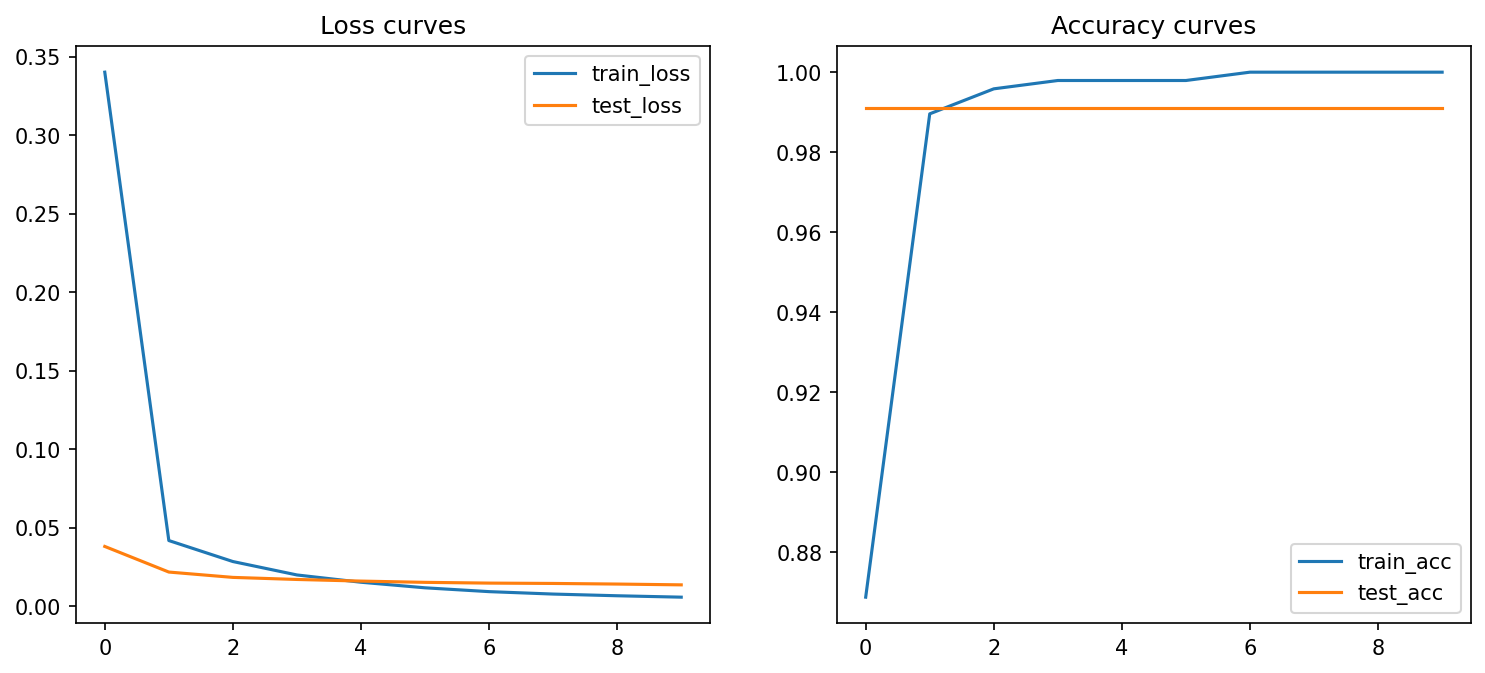

In [ ]:
fig,ax = plt.subplots(1,2,dpi=150,figsize=(12,5))

ax[0].plot(results['train_loss'],label='train_loss')
ax[0].plot(results['test_loss'],label='test_loss')
ax[0].set_title('Loss curves')
ax[0].legend()

ax[1].plot(results['train_acc'],label='train_acc')
ax[1].plot(results['test_acc'],label='test_acc')
ax[1].set_title('Accuracy curves')
ax[1].legend()

plt.show()

# ex:5
* Our custom ViT model architecture closely mimics that of the ViT paper, however, our training recipe misses a few things. Research some of the following topics from Table 3 in the ViT paper that we miss and write a sentence about each and how it might help with training:
1. ImageNet-21k pretraining (more data).
2. Learning rate warmup.
3. Learning rate decay.
4. Gradient clipping.


## 1. what more data would have done to our model?
* more data, more accuracy.
* more training time.


## 2. Learning rate warmup:
* using a larger learning rate might make the gradient to explode and using a very smaller learning rate might make it get vanished.
* learning rate warmup is the concept of using smaller gradient in the beginning and slowly increase it, like a marathon runner pacing up at then end of the race, to reach the ideal minimum point on the gradient function.
* this helps avoid explosion and vanishing. and this would also help regularize the model quite well and therefore avoid sharp troughs and approach only a flatter global minimum to generalize well on unseen data.

## 3. Learning rate decay:
* the idea of learning rate decay is when the model has found a minimal point on the loss landscape, a little nudge is given to move a little further to see if the model's accuracy could further be improved. This nudge is called learning rate decay
* it helps faster convergence, avoid saddle points or sub-optimal local minima's and also regularize the model well to unseen data by finding a wider global minima while avoiding sharp edges.

## 4.Gradient Clipping:
* gradient clipping is the idea of using a threshold for the learning rate up until which point can the increasing learning rate can go but beyond it No!
* for example you can set the learning rate at 0.01 and increases slowly as in learning rate warmpup, slowly but surely, and the learning rate is clipped(thresholded) to be the maximum at 0.1. so, Learning rate cannot go beyond.
* this helps avoid exploding gradient that may result from too large of a learning rate.

# ex 6: Jay Alamar's blog on Attention:



In [ ]:
from IPython.display import display,Video
video_url = 'https://jalammar.github.io/images/seq2seq_1.mp4'
display(Video(video_url,height=500,width=800))

In [ ]:
from IPython.display import display,Video
video_url = 'https://jalammar.github.io/images/seq2seq_2.mp4'
display(Video(video_url,height=500,width=800))

In [ ]:
from IPython.display import display,Video
video_url = 'https://jalammar.github.io/images/seq2seq_3.mp4'
display(Video(video_url,height=500,width=800))

In [ ]:
from IPython.display import display,Video
video_url = 'https://jalammar.github.io/images/seq2seq_4.mp4'
display(Video(video_url,height=500,width=800))

## notes:
* encoder and decoder are RNN(Recurrent Neural Networks)

![fssdf](https://jalammar.github.io/images/context.png)

## notes:
* context is vector of floats.
* You can set the size of the context vector when you set up your model. It is basically the number of hidden units in the encoder RNN. These visualizations show a vector of size 4, but in real world applications the context vector would be of a size like 256, 512, or 1024.


## conversion of words to vectors:
* The encoder takes in a hidden state and word from the input sentence each time.
* Each word in the input sentence is fed into the encoder one by one.
* These words are converted into vectors which are known as word embeddings.
* This conversion helps preserve the sementic relationship between each word in the sentence such as (king - man + woman = Queen).

In [ ]:
from IPython.display import display,Video
video_url = 'https://jalammar.github.io/images/RNN_1.mp4'
display(Video(video_url,height=500,width=800))

## notes:
* The RNN takes in hidden state0 and the input vector and outputs hidden state1 and the output vector

In [ ]:
from IPython.display import display,Video
video_url = 'https://jalammar.github.io/images/seq2seq_5.mp4'
display(Video(video_url,height=500,width=800))

## notes:
* notice the last hidden state is the context(decoder-ready vector) for the decoder

In [ ]:
from IPython.display import display,Video
video_url = 'https://jalammar.github.io/images/seq2seq_6.mp4'
display(Video(video_url,height=500,width=800))

## notes:
* just a detailed explanation of the above process

## ATtention:

* attention mechanism helped the model to focus on the relevant part of the input sequence which helped yield a tremendous boost in prediction accuracy

In [ ]:
from IPython.display import display,Video
video_url = 'https://jalammar.github.io/images/seq2seq_7.mp4'
display(Video(video_url,height=500,width=800))

## notes:
* the main difference is instead of passing just the last hidden state of the encoder, we now pass all the hidden states of all the encoders.

In [ ]:
from IPython.display import display,Video
video_url = 'https://jalammar.github.io/images/attention_process.mp4'
display(Video(video_url,height=500,width=800))

## notes:
* Second, an attention decoder does an extra step before producing its output. In order to focus on the parts of the input that are relevant to this decoding time step, the decoder does the following:

* Look at the set of encoder hidden states it received – each encoder hidden state is most associated with a certain word in the input sentence
* Give each hidden state a score (let’s ignore how the scoring is done for now)
* Multiply each hidden state by its softmaxed score, thus amplifying hidden states with high scores, and drowning out hidden states with low scores

In [ ]:
from IPython.display import display,Video
video_url = 'https://jalammar.github.io/images/seq2seq_9.mp4'
display(Video(video_url,height=500,width=800))

![sfs](https://jalammar.github.io/images/attention_sentence.png)

## notes:
You can see how the model paid attention correctly when outputing "European Economic Area". In French, the order of these words is reversed ("européenne économique zone") as compared to English. Every other word in the sentence is in similar order.


# jay alamar's Illustrated Transformer:

## what does the transformer do?

* it uses self attention technique that we have learned above.
* it boosts the speed with which models are trained.

## overview:
![sfsf](https://jalammar.github.io/images/t/the_transformer_3.png)

![fsfs](https://jalammar.github.io/images/t/The_transformer_encoders_decoders.png)

![fsfsd](https://jalammar.github.io/images/t/The_transformer_encoder_decoder_stack.png)

### notes:
* the number of encoder and decoder being 6 is just arbitrary selection, it can be of any number.

* the encoders are all identical but they do not share same weights(each to their own).

![sfsdf](https://jalammar.github.io/images/t/Transformer_encoder.png)

![dfff](https://jalammar.github.io/images/t/Transformer_decoder.png)

### mechanism:
![fsfs](https://jalammar.github.io/images/t/embeddings.png)
![fsfs](https://jalammar.github.io/images/t/encoder_with_tensors.png)
![affsafd](https://jalammar.github.io/images/t/encoder_with_tensors_2.png)
![sfsf](https://jalammar.github.io/images/t/transformer_self-attention_visualization.png)

* first each word is converted into a vector independently.
* then, in the encoder each of these vectors get passed into the self attention layer which further transforms into becoming three different vectors with different weights.
* just to sum it up, the first encoder receives a bunch of vectors, these are passed into a self attention layer, then these are passed into a feed forward layer(dense layer) then these transformed vectors are passed into the next encoder down the lane.
* RNN incorporates the vectors of the previous word with the current one. similarly self-attention is about the algorithm understanding how the previous words it has processes in the sequence relates to the current word it is processing.
* Through self attention layer the algorithm will understand that the "it" in the sentence is actually referring to the "animal".

## what are the query,key and value vectors?
![asdfsaf](https://jalammar.github.io/images/t/transformer_self_attention_vectors.png)

* Multiplying x1 by the WQ weight matrix produces q1, the "query" vector associated with that word. We end up creating a "query", a "key", and a "value" projection of each word in the input sentence.

![sfsfs](https://jalammar.github.io/images/t/transformer_self_attention_score.png)
![sfsdfsd](https://jalammar.github.io/images/t/self-attention_softmax.png)
![sfsfsf](https://jalammar.github.io/images/t/self-attention-output.png)
* each word in the sequence is given a score. the score is created by taking the dot product of the current word's query vector with the key vector of every other word in the sequence key vector.
*  Then this score is divided by the dimension( in the case of word processing the dimension is the length of the longest sentence).
* Then we put the thus obtained value inside a softmax function. Then multiplied with a value vector.


## matrix for faster processing
![fsf](https://jalammar.github.io/images/t/self-attention-matrix-calculation.png)
![sfsdf](https://jalammar.github.io/images/t/self-attention-matrix-calculation-2.png)

* Every row in the X matrix corresponds to a word in the input sentence. We again see the difference in size of the embedding vector (512, or 4 boxes in the figure), and the q/k/v vectors (64, or 3 boxes in the figure)

## multi head attention for better understanding of the patterns:
![ffsds](https://jalammar.github.io/images/t/transformer_attention_heads_qkv.png)

* It expands the model’s ability to focus on different positions. Yes, in the example above, z1 contains a little bit of every other encoding, but it could be dominated by the actual word itself. If we’re translating a sentence like “The animal didn’t cross the street because it was too tired”, it would be useful to know which word “it” refers to.


![sffa](https://jalammar.github.io/images/t/transformer_attention_heads_z.png)

* If we do the same self-attention calculation we outlined above, just eight different times with different weight matrices, we end up with eight different Z matrices

![fss](https://jalammar.github.io/images/t/transformer_attention_heads_weight_matrix_o.png)

![fff](https://jalammar.github.io/images/t/transformer_attention_heads_weight_matrix_o.png)

* This leaves us with a bit of a challenge. The feed-forward layer is not expecting eight matrices – it’s expecting a single matrix (a vector for each word). So we need a way to condense these eight down into a single matrix.How do we do that? We concat the matrices then multiply them by an additional weights matrix WO.

## all the processes in one image:
![fsfsa](https://jalammar.github.io/images/t/transformer_multi-headed_self-attention-recap.png)

## residual is accounted for using LayerNorm
![sfsfsd](https://jalammar.github.io/images/t/transformer_resideual_layer_norm_3.png)

## mechanics:
![sfsf](https://jalammar.github.io/images/t/transformer_decoding_1.gif)
![sdfsd](https://jalammar.github.io/images/t/transformer_decoding_2.gif)





## Layer Normalization:

* if you use fewer batches then doing Batch normalization(normalize batch wise) might give less precise mean and variance of data, potentially affecting the accuracy or performance of the data.
* But if you have only limited data or you are working with RNN like neural networks then use LayerNorm. This type of normalization is sequence-aware (it can work with fewer batches or sequence of inputs rather than forcefully working with the entire batches).




# $$ \text{understanding: } softmax(\frac{Q.k^T}{\sqrt{D}}) . V $$

* when the dot product of q and k (query and key of the concerned word/object) is zero which means they are perpendicular, then the softmax function would make it zero probability. That means the Attention algorithm is not going to pay attention to the concerned word/object/image or whatever.
* when the q and k have linearly dependent values then they may scale the magnitude up and therefore get a higher probability from softmax and therefore would draw a lot of attention from the attention algorithm.

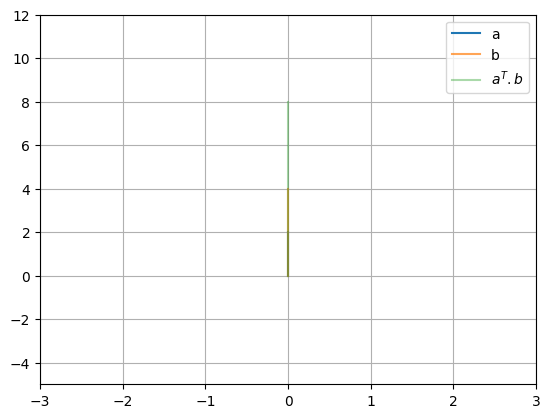

In [28]:
# norm of the linearly dependent vectors vs norm of them individually
a = np.array([0,2])
b = np.array([0,4])

dot_product = a.T@b

plt.plot([0,a[0]],[0,a[1]],label='a',alpha=1)
plt.plot([0,b[0]],[0,b[1]],label='b',alpha=0.7)
plt.plot([0,0],[0,dot_product],label='$a^{T}.b$',alpha=0.4)

plt.xlim([-3,3])
plt.ylim([-5,12])
plt.legend()
plt.grid()
plt.show()

In [19]:
np.linalg.norm(a),np.linalg.norm(b),np.linalg.norm(dot_product)

(2.0, 4.0, 8.0)

# how softmax function works:

![sfsf](https://docs-assets.developer.apple.com/published/c2185dfdcf/0ab139bc-3ff6-49d2-8b36-dcc98ef31102.png)

In [36]:
a = torch.tensor([1,2],dtype=torch.float32)

torch.softmax(a,dim=0)

tensor([0.2689, 0.7311])

# transformer:
* Transformer algorithm is the most generalizable algorithm in the deep learning field to date.
* it is the generalization of multi layer perceptrons. while CNN and LSTM are specialized algorithms of MLP.
